# Team Ernst Engel Nutritional Content Notebook
In this notebook, we obtain the nutritional contents for the foods of interest for our project.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, widgets
import fooddatacentral as fdc

# This is a local file unique to Jordan's computer
# It contains his USDA FoodData Central API Key
# Keep Commented or it will cause an error
import config

## Getting Nutritional Contents

In [5]:
foods_oi = pd.read_csv('./data/foods_oi.csv').set_index('Food')
apikey = config.API_KEY
diet_refs = pd.read_csv('./data/us_diet_minimums.csv')
dr_categories = diet_refs['Nutrition'].values

In [6]:
def get_nutritional_content(foods_oi, apikey, dr_categories):
    '''
    Description
    --------------------------------------------------
    Gets the nutritional content for the food of 
    interest.
    
    Inputs
    --------------------------------------------------
    + foods_oi : pandas dataframe; foods of interest
        with their FDC id
    + apikey : string; FoodData Central API key
    + dr_categories : array; USDA dietary requirment
        categories
    
    Outputs
    --------------------------------------------------
    + food_nutrients : pandas dataframe; contains the
        nutritional contents of all foods of interest
        for the dr_categories
    '''
    food_nutrients = {}
    for food in foods_oi.index:
        try:
            FDC = foods_oi.loc[food,'FDC']
            food_nutrients[food] = fdc.nutrients(apikey,FDC).Quantity
        except:
            pass

    food_nutrients = pd.DataFrame(food_nutrients,dtype=float)

    food_nutrients = food_nutrients[food_nutrients.index.isin(dr_categories)].fillna(0)
    return food_nutrients

In [768]:
# food_nutrients = get_nutritional_content(foods_oi, apikey, dr_categories)

## Examing Nutritional Adequacy

In [9]:
diet_refs = pd.read_csv('./data/uganda/rdi.csv')
dr_categories = diet_refs['n'].values

In [ ]:
country = 'uganda'
year_range = '2019-20'

In [765]:
food_nutrients = pd.read_csv(f'./data/{country}/fct.csv')#.set_index('n')
food_prices = pd.read_csv(f'./data/{country}/food_prices.csv').fillna(0)
hh_chars = pd.read_csv(f'./data/{country}/hh_chars.csv')

### Deals With Housholds from an  Unknown Region
hh_chars['m'] = hh_chars['m'].fillna('Unknown')
expenditures = pd.read_csv(f'./data/{country}/expenditures_{year_range[-5:]}.csv').fillna(0)

In [726]:
hhc_sub = hh_chars[hh_chars['t'] == year_range].reset_index(drop = True)
fp_sub = food_prices[food_prices['t'] == year_range].set_index('m').drop(columns = ['t'])
food_cols = expenditures.iloc[0:2, 3:].columns
fp_sub_avgs = fp_sub.reset_index(drop = True)
fp_sub_avgs = pd.DataFrame(fp_sub_avgs.mean()).rename(columns = {0 : 'Mean_Price'})

In [728]:
def get_col_counts(expenditures_df, food_col, prices, price_avs):
    counts = []
    for idx in expenditures_df.index:
        region = expenditures_df.loc[idx, 'm']
        expenditure = expenditures_df.loc[idx, food_col]
        if region == 'Unknown':
            # Imputes price from unknown region with the mean accross all regions
            price = fp_sub_avgs.loc[food_col][0]
            if price == 0: # Don't want to divide by zero
                count = 0
                counts.append(count)
            else:
                count = expenditure / price
                counts.append(count)   
        else:
            price = prices.loc[region, food_col]
            if price == 0: # Don't want to divide by zero
                count = 0
                counts.append(count)
            else:
                count = expenditure / price
                counts.append(count)
    return counts

In [730]:
def get_counts(expenditures_df, food_cols, prices, price_avs):
    count_df = expenditures_df.drop(columns = food_cols)
    for food_col in food_cols:
        counts = get_col_counts(expenditures_df, food_col, prices, price_avs)
        count_df[food_col] = counts
    return count_df

In [732]:
exp_counts = get_counts(expenditures, food_cols, fp_sub, fp_sub_avgs)
exp_counts['i'] = exp_counts['i'].astype(str)

In [733]:
household_master = hhc_sub.merge(exp_counts, left_on = ['i', 't', 'm'], right_on = ['i', 't', 'm'])
hhc_sub_num = hhc_sub.set_index('i').iloc[:, 2:-1]

In [734]:
# If expenditures weekly, extrapolation_constant = 7
# If expenditures daily, extrapolation_constant = 1
extrapolation_constant = 7

# Commented b/c we working with the Uganda data rn
# diet_refs_rev = diet_refs.set_index('Nutrition').drop(columns = ['Source']).rename(columns = {'C 1-3' : 'F 00-03', 
#                                                                                               'F 4-8' : 'F 04-08',
#                                                                                               'M 4-8' : 'M 04-08',
#                                                                                               'F 9-13' : 'F 09-13',
#                                                                                               'M 9-13' : 'M 09-13'})
# diet_refs_rev['M 00-03'] = diet_refs_rev['F 00-03']
diet_refs_rev = diet_refs.set_index('n')
diet_refs_rev = diet_refs_rev[hhc_sub_num.columns] # Reorders columns
diet_refs_rev = extrapolation_constant * diet_refs_rev

In [735]:
hh_diet_reqs = hhc_sub_num @ diet_refs_rev.T

In [736]:
hh_consumption_cols = list(food_cols.to_numpy())
hh_consumption_cols.append('i')

hh_consumption = household_master[hh_consumption_cols].set_index('i')

In [737]:
fn_rev = food_nutrients[food_nutrients['j'].isin(hh_consumption.columns)].rename(columns = {'j' : 'Food'}).set_index('Food')

hh_consumption_rev = hh_consumption[fn_rev.index.to_numpy()]

hh_consumption_nutrients = hh_consumption_rev @ fn_rev

In [738]:
common_columns = hh_consumption_nutrients.columns.intersection(hh_consumption_nutrients.columns)
common_rows = set(hh_consumption_nutrients.index).intersection(hh_consumption_nutrients.index)

### Gets common columns
hh_consumption_nutrients_rev = hh_consumption_nutrients[common_columns]
hh_diet_reqs_rev = hh_diet_reqs[common_columns]

### Gets common rows
hh_consumption_nutrients_rev = hh_consumption_nutrients_rev[hh_consumption_nutrients_rev.index.isin(common_rows)]
hh_diet_reqs_rev = hh_diet_reqs_rev[hh_diet_reqs_rev.index.isin(common_rows)]

In [739]:
hh_diet_adequacy = hh_consumption_nutrients_rev / hh_diet_reqs_rev
nutrient_cols = hh_diet_adequacy.columns

In [740]:
hh_diet_adequacy['adequate_diet'] = (hh_diet_adequacy >= 1).sum(axis=1) / len(nutrient_cols)
hh_diet_adequacy['adequate_diet_75pct'] = (hh_diet_adequacy >= 0.75).sum(axis=1) / len(nutrient_cols)
hh_diet_adequacy['adequate_diet_50pct'] = (hh_diet_adequacy >= 0.5).sum(axis=1) / len(nutrient_cols)
hh_diet_adequacy = hh_diet_adequacy[~hh_diet_adequacy.isin([np.inf]).any(axis=1)] # Drops infinite values

## Plotting Nutritional Accuracy

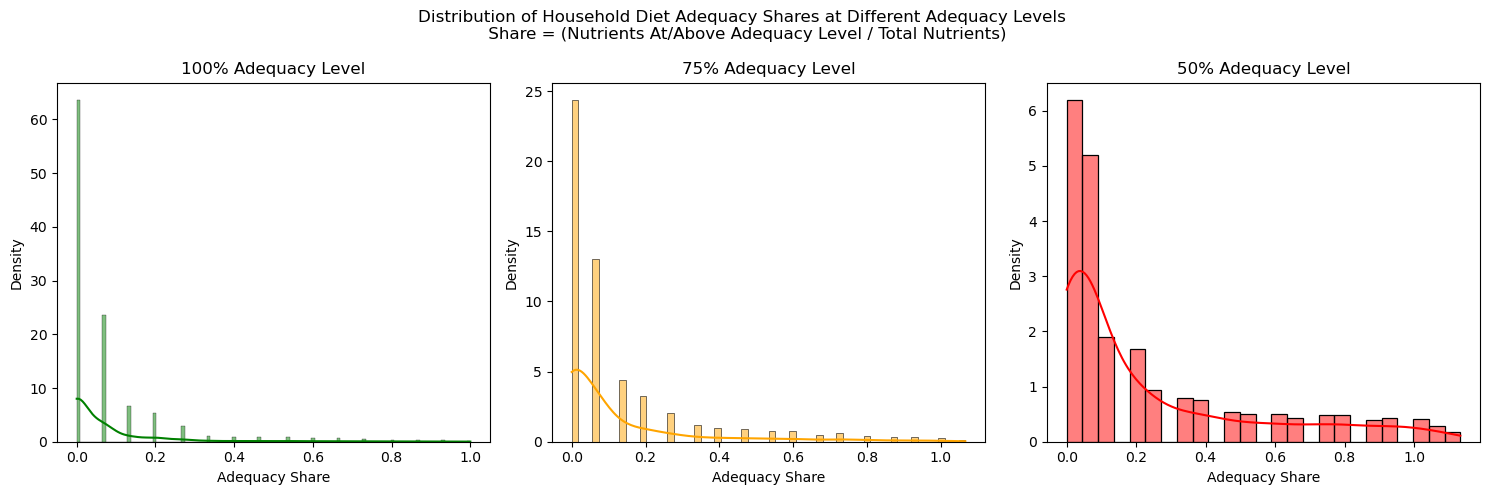

In [742]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data = hh_diet_adequacy, x = 'adequate_diet', 
             stat='density', kde = True, color = 'green', ax = axs[0])
sns.histplot(data = hh_diet_adequacy, x = 'adequate_diet_75pct', 
             stat='density', kde = True, color = 'orange', ax = axs[1])
sns.histplot(data = hh_diet_adequacy, x = 'adequate_diet_50pct', 
             stat='density', kde = True, color = 'red', ax = axs[2])

plt.suptitle('Distribution of Household Diet Adequacy Shares at Different Adequacy Levels \n Share = (Nutrients At/Above Adequacy Level / Total Nutrients)')

axs[0].set_title('100% Adequacy Level')
axs[1].set_title('75% Adequacy Level')
axs[2].set_title('50% Adequacy Level')

for ax in axs:
    ax.set_xlabel('Adequacy Share')

plt.tight_layout()

# Show the plots
plt.show();

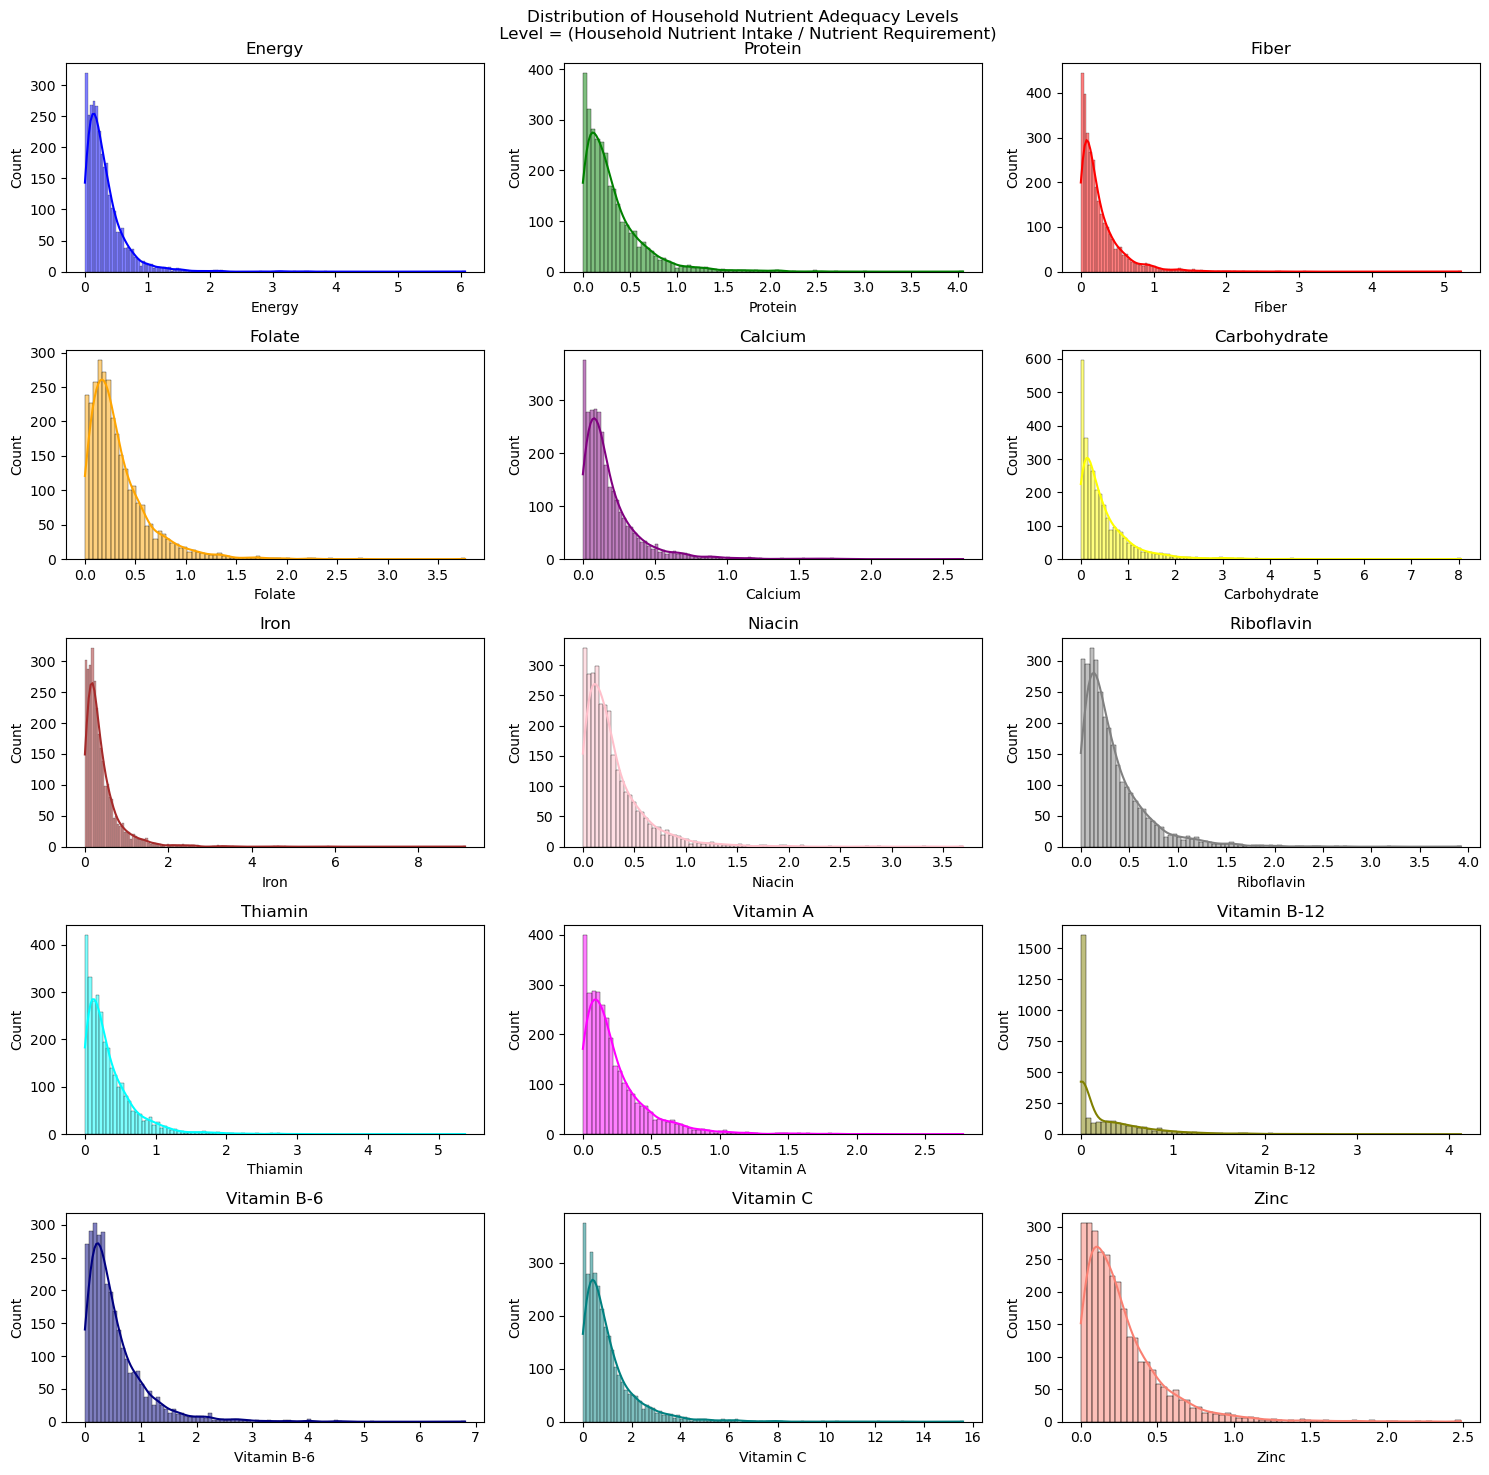

In [743]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

axs = axs.flatten()

colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive', 'navy', 'teal', 'salmon']

plt.suptitle('Distribution of Household Nutrient Adequacy Levels \n Level = (Household Nutrient Intake / Nutrient Requirement)')

for i, col in enumerate(nutrient_cols):
    color = colors[i]
    sns.histplot(hh_diet_adequacy[col], ax=axs[i], kde=True, color=color)
    axs[i].set_title(col)

plt.tight_layout()

In [744]:
adequacy_shares = (hh_diet_adequacy >= 1).mean()
adequacy_shares_75pct = (hh_diet_adequacy >= 0.75).mean()
adequacy_shares_50pct = (hh_diet_adequacy >= 0.5).mean()

# Calculate the average value of each column
avg_shares = hh_diet_adequacy.mean()

# Create a new DataFrame with the percentage over 1 and average values, indexed by column names
adequacy_shares_summary = pd.DataFrame({'Average Share': avg_shares, 
                                        'Adequacy Level (Full)': adequacy_shares,
                                       'Adequacy Level (75%)': adequacy_shares_75pct,
                                       'Adequacy Level (50%)': adequacy_shares_50pct})
adequacy_shares_summary = adequacy_shares_summary[adequacy_shares_summary.index.isin(nutrient_cols)]

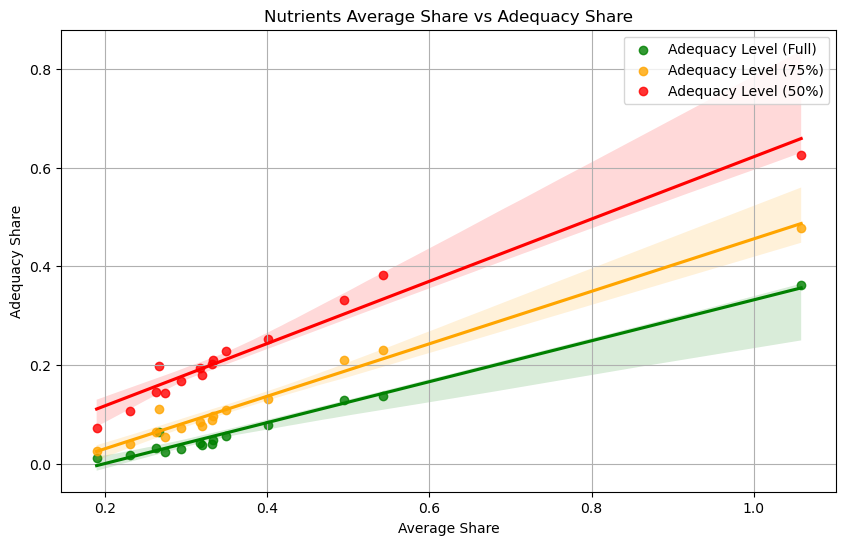

In [754]:
colors = ['green', 'orange', 'red']

plt.figure(figsize=(10, 6))

for i, (col, color) in enumerate(zip(adequacy_shares_summary.columns[1:], colors)):
    sns.regplot(x='Average Share', y=col, data = adequacy_shares_summary,
                scatter= True, color = color, label = col)

plt.xlabel('Average Share')
plt.ylabel('Adequacy Share')
plt.title('Nutrients Average Share vs Adequacy Share')
plt.legend()
plt.grid(True)
plt.show()

In [755]:
adequacy_shares_summary.sort_values('Average Share', ascending = False).head()

,Average Share,Adequacy Level (Full),Adequacy Level (75%),Adequacy Level (50%)
Vitamin C,1.058585,0.363153,0.478217,0.625540
Vitamin B-6,0.543145,0.138344,0.229797,0.382774
Carbohydrate,0.494387,0.129365,0.210841,0.330895
Iron,0.400802,0.078151,0.131693,0.253741
Thiamin,0.349545,0.056535,0.109744,0.228467


In [757]:
hh_diet_adequacy.reset_index(inplace = True)
hh_diet_adequacy['m'] = household_master['m']
hh_diet_adequacy = hh_diet_adequacy.set_index(['i', 'm']).reset_index().set_index('i')

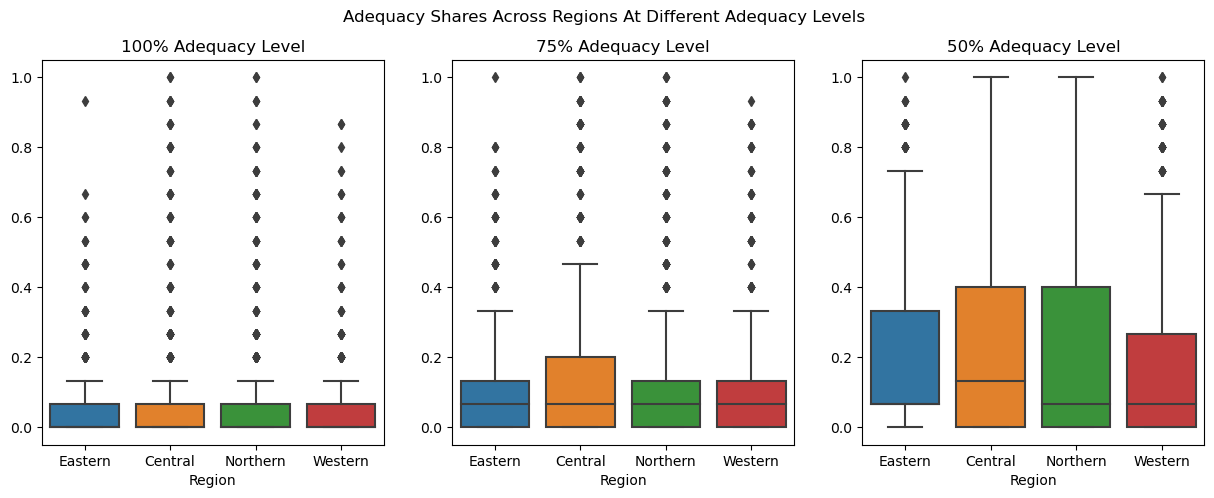

In [758]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
adequacy_levels = [1, 0.75, 0.5]
a_lvl_titles = ['100% Adequacy Level', '75% Adequacy Level', '50% Adequacy Level']
colors = ['green', 'orange', 'red']

plt.suptitle('Adequacy Shares Across Regions At Different Adequacy Levels')

for i, a_lvl in enumerate(adequacy_levels):
    hh_diet_adequacy_by_region = hh_diet_adequacy.set_index('m').iloc[:, :len(nutrient_cols)]
    hh_diet_adequacy_by_region = (hh_diet_adequacy_by_region >= a_lvl).sum(axis = 1) / len(nutrient_cols)
    color = colors[i]
    axs[i].set_title(a_lvl_titles[i])
    sns.boxplot(x = hh_diet_adequacy_by_region.index,
               y = hh_diet_adequacy_by_region.values, ax = axs[i])

for ax in axs:
    ax.set_xlabel('Region')